In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
datapath = "../data/data/v2.0/"
import csv
from collections import defaultdict
import seaborn as sn
from numpy.random import default_rng
from sklearn import tree
import decisiontree as dt
# code\data\data\v2.0\hipe2020\en\HIPE-2022-v2.0-hipe2020-dev-en.tsv

In [2]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [3]:
english_dataframe = pd.read_csv(datapath+"hipe2020/en/HIPE-2022-v2.0-hipe2020-dev-en.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)

In [4]:
misc_list = english_dataframe["MISC"].to_list()

In [5]:
sentence_idx = []
idx = 0
for item in misc_list:
    sentence_idx.append(idx)
    if "EndOfSentence" in item:
        idx += 1
english_dataframe["SENTENCE_ID"] = sentence_idx

In [192]:
np.save("sentence idx", sentence_idx)

In [6]:
labelled_sentences = set()
for i, label in enumerate(english_dataframe["NE-COARSE-LIT"].to_list()):
    if label != "O":
        labelled_sentences.add(sentence_idx[i])

In [148]:
english_dataframe

,TOKEN,NE-COARSE-LIT,NE-COARSE-METO,NE-FINE-LIT,NE-FINE-METO,NE-FINE-COMP,NE-NESTED,NEL-LIT,NEL-METO,MISC,SENTENCE_ID
0,From,O,O,_,_,_,_,_,_,_,0
1,the,O,O,_,_,_,_,_,_,_,0
2,AMERICAN,B-prod,O,_,_,_,_,NIL,_,_,0
3,MERCURY,I-prod,O,_,_,_,_,NIL,_,NoSpaceAfter,0
4,EndOfSentence,O,O,_,_,_,_,_,_,EndOfLine|EndOfSentence,0
...,...,...,...,...,...,...,...,...,...,...,...
29054,Booth,O,O,_,_,_,_,_,_,_,1044
29055,of,O,O,_,_,_,_,_,_,_,1044
29056,course,O,O,_,_,_,_,_,_,NoSpaceAfter,1044
29057,),O,O,_,_,_,_,_,_,NoSpaceAfter,1044


In [150]:
token_dict = english_dataframe["TOKEN"].str.lower().value_counts().to_dict()


In [147]:
temp_data_frame = english_dataframe.copy()
temp_data_frame["TOKEN"][temp_data_frame["MISC"].str.contains("EndOfSentence")] = "EndOfSentence"

C:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
NE_dict = english_dataframe[english_dataframe["NE-COARSE-LIT"] != "O"]["TOKEN"].value_counts().to_dict()

In [151]:
feature_list = []
total_word_count = len(english_dataframe)
total = 0
for key in token_dict:
    total += token_dict[key]
    feature_list.append(key)
    if total > total_word_count * 0.5:
        break
print(total)
print(feature_list)
print(len(feature_list))

14542
[',', 'the', 'of', 'endofsentence', 'and', 'to', 'a', '¬', 'in', '.', 'is', '-', 'that', 'for', 'he', 'be', 'as', 'was', 'it', 'at', 'on', 'by', 'with', 'this', 'will', 'have', 'from', '’', 'his', 'are', 'i', 'their', ';', 'which', 's', 'not', 'they', 'has', '*', "'", '“', 'you', 'or', 'an', 'one', 'all', 'we', 'been', 'but', 'no', 'who', 'were', 'our', 'than', 'other', 'county', '—', 'them', 'any', 'man', 'when', '”', 'made', 'new', 'more', 'j', 'out', 'there', 'can', 'may', 'would', 'day', 'its', ':', 'had']
75


In [153]:
post_fix_dict_3 = defaultdict(lambda:0)
post_fix_dict_2 = defaultdict(lambda:0)
post_fix_3_list = []
post_fix_2_list = []
for key in token_dict:
    if key == "endofsentence":
        continue
    if len(key) <= 2:
        continue
    count = token_dict[key]
    
    if len(key) == 3:
        post_fix_2 = key[-2:]
        post_fix_dict_2[post_fix_2] += count
        if post_fix_dict_2[post_fix_2] >= 30 and post_fix_2 not in post_fix_2_list:
            post_fix_2_list.append(post_fix_2)
        continue

    post_fix_3 = key[-3:]
    post_fix_dict_3[post_fix_3] += count
    if post_fix_dict_3[post_fix_3] >= 30 and post_fix_3 not in post_fix_3_list:
            post_fix_3_list.append(post_fix_3)
    

In [154]:
len(post_fix_2_list)

28

In [155]:
label_list =  list(pd.unique(english_dataframe["NE-COARSE-LIT"]))

In [156]:
feature_matrix = []
label_matrix = []
pos_dict = defaultdict(lambda: [])
label_dict = defaultdict(lambda: [])
pos = 0
progress = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
prev_label = 0
extra_features = 6
check = True
for idx in english_dataframe.index:
    if idx/len(english_dataframe) > progress[0]:
        print(progress[0])
        progress.pop(0)
    pos += 1
    row = english_dataframe.iloc[idx]
    token = row["TOKEN"]
    if isinstance(token, float): #null in the tsv is taken as a nan value
        token = "null"
    prev_label = label
    label = int(row["NE-COARSE-LIT"] != "O")
    if token.lower() in feature_list:
        pos_dict[token.lower() ].append(pos)
    if "EndOfSentence" not in row["MISC"]:
        label_dict[token].append((pos,label,prev_label,0))
        continue
    label_dict[token].append((pos,label,prev_label,1))
    # loop of all tokens in a sentence
    for token in label_dict:
        # loop over all ocurances of a token
        for item in label_dict[token]:
            feature_vector = np.zeros(shape = (len(feature_list)+extra_features)) #differntiate between wheter a token occurs or wheter the current token is in the top 50%
            # label_vector = np.zeros(shape=(2))
            current_pos = item[0]
            
            # loop over all features present in a sentence
            for feature in pos_dict:
                closest_pos = pos_dict[feature][0] - current_pos # starting point
                
                # loop over all occurences of a feature present in a sentence
                for pos in pos_dict[feature]:
                    relative_pos = pos - current_pos
                    if abs(relative_pos) < abs(closest_pos):
                        closest_pos = relative_pos
                    else: break
                feature_vector[feature_list.index(feature)] = closest_pos
            feature_vector[-1] = item[0] # add location as feature
            feature_vector[-2] = item[3] # add wheter the item is the end of a sentence
            feature_vector[-3] = int(token[0].isupper()) #add wheter the first char is a capital letter
            feature_vector[-4] = int(any(char.isdigit() for char in token))
            
            if len(token) > 3:
                post_fix = token[-3:].lower()
                if post_fix in post_fix_3_list:
                    feature_vector[-5] = post_fix_3_list.index(post_fix) + 1
                    check = False
                # print(post_fix)
            if len(token) > 2:
                post_fix = token[-2:].lower()
                if post_fix in post_fix_2_list:
                    feature_vector[-6] = post_fix_2_list.index(post_fix) + 1
                # print(post_fix)
            # if not check:
            #     print(token)
            #     break
            feature_matrix.append(feature_vector)
            # label_vector[item[1]] = 1
            label_matrix.append(item[1])
    # break
    pos = 0
    pos_dict = defaultdict(lambda: [])
    label_dict = defaultdict(lambda: [])
    prev_label = 0
feature_matrix = np.array(feature_matrix)
label_matrix = np.array(label_matrix)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [170]:
print(feature_matrix)

[[  0.   1.   0. ...   1.   0.   1.]
 [  0.   0.   0. ...   0.   0.   2.]
 [  0.  -1.   0. ...   1.   0.   3.]
 ...
 [-59. -24.   0. ...   0.   0. 142.]
 [-60. -25.  -1. ...   0.   0. 143.]
 [-62. -27.  -3. ...   1.   1. 145.]]


In [158]:
print(feature_matrix.shape)
print(len(sentence_idx))

(29059, 81)
29059


In [171]:
print(label_matrix)

[0 0 1 ... 0 0 0]


In [124]:
print(sum(label_matrix))

2775


In [191]:
np.save("feature matrix", feature_matrix)
np.save("label matrix", label_matrix)

In [172]:
total_sentences = len(set(sentence_idx))
split = 0.5
rng = default_rng()
training_sentence_ids = rng.choice(total_sentences, size=int(total_sentences*split), replace=False)
test_sentence_ids = [i for i in range(total_sentences) if i not in training_sentence_ids]

training_id_list = []
test_id_list = []
for i, item in enumerate(sentence_idx):
    if item in training_sentence_ids:
        training_id_list.append(i)
    else:
        test_id_list.append(i)

training_feature_matrix = np.array([feature_matrix[i] for i in training_id_list])
training_label_matrix = np.array([label_matrix[i] for i in training_id_list])
test_feature_matrix = np.array([feature_matrix[i] for i in test_id_list])
test_label_matrix = np.array([label_matrix[i] for i in test_id_list])

In [183]:
print(training_feature_matrix)

[[  0.   1.   0. ...   1.   0.   1.]
 [  0.   0.   0. ...   0.   0.   2.]
 [  0.  -1.   0. ...   1.   0.   3.]
 ...
 [-59. -24.   0. ...   0.   0. 142.]
 [-60. -25.  -1. ...   0.   0. 143.]
 [-62. -27.  -3. ...   1.   1. 145.]]


In [190]:
import decisiontree as dt

In [189]:
test_classifier = dt.custom_decision_tree(training_feature_matrix, training_label_matrix, discrete_idx_list=[-2,-3,-4,-5,-6], min_samples=35)
test_classifier.build_tree()

TypeError: only integer scalar arrays can be converted to a scalar index

In [160]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=30)
clf.fit(training_feature_matrix,training_label_matrix)

DecisionTreeClassifier(min_samples_leaf=30)

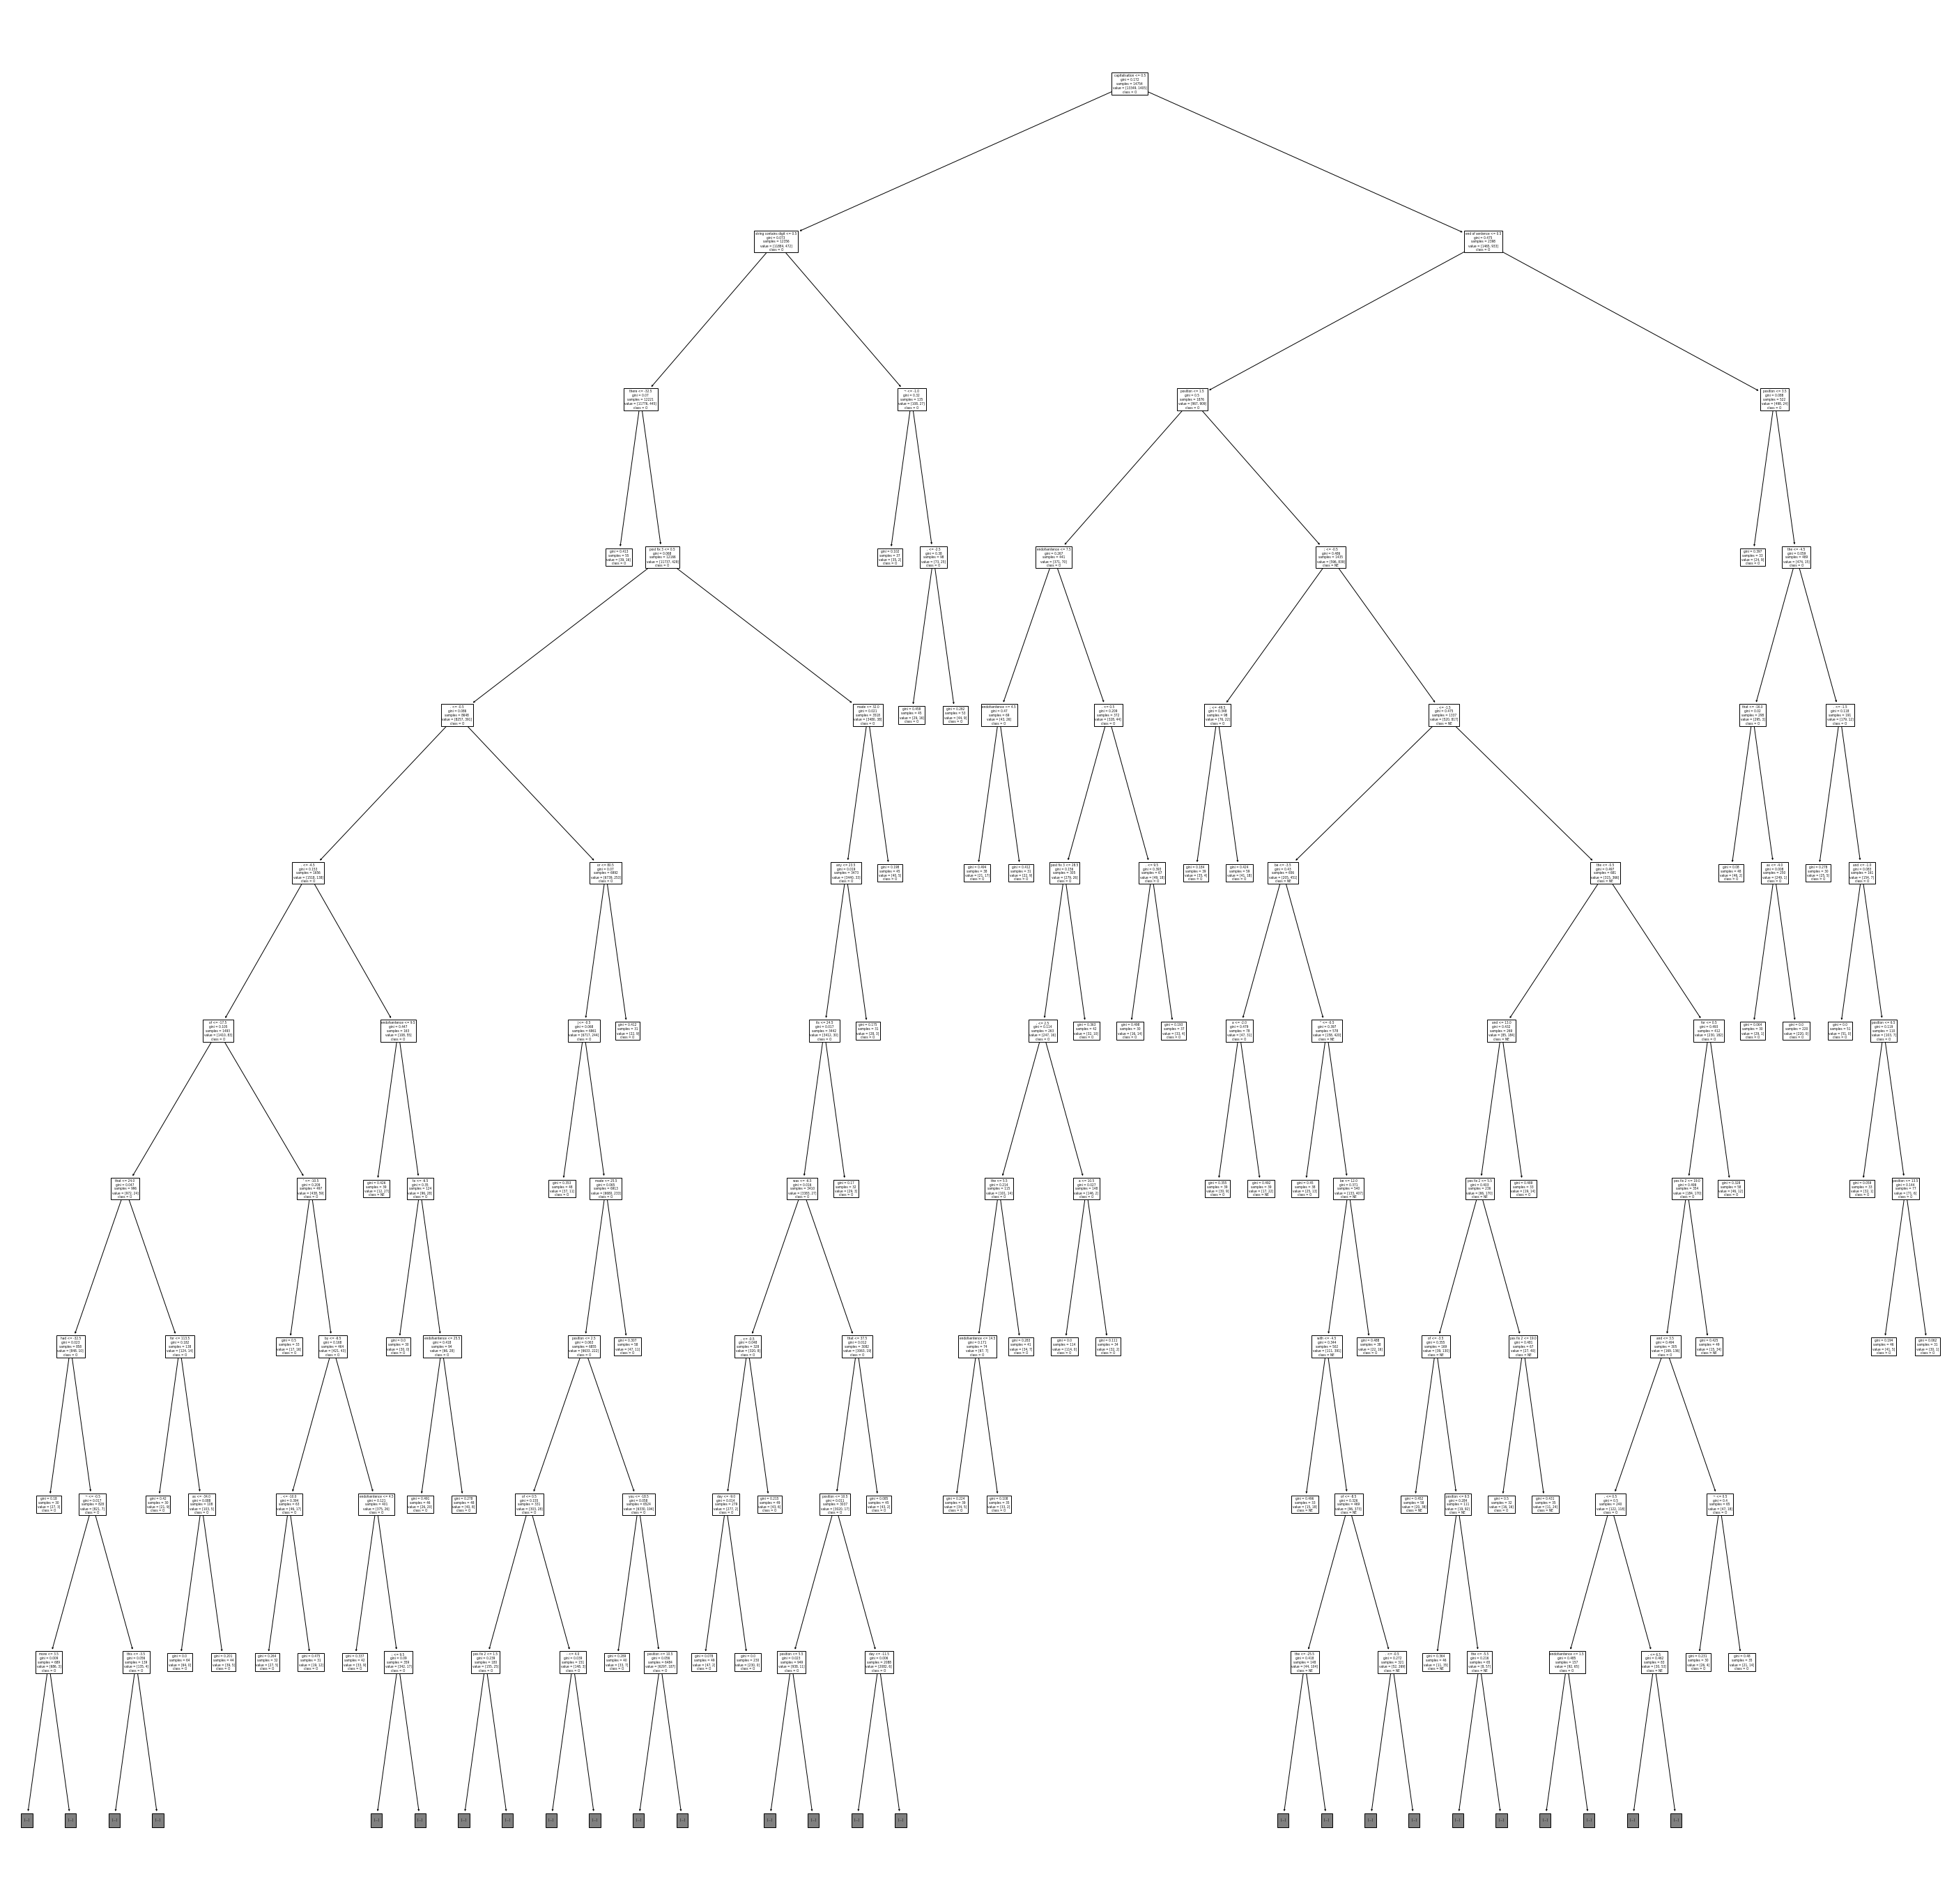

In [166]:
plt.figure(figsize=(50,50))
tree.plot_tree(clf,feature_names = feature_list + ["pos fix 2", "post fix 3", "string contains digit", "capitalisation", "end of sentence", "position"], class_names = ["O", "NE"], max_depth=10)
plt.show()

In [161]:
tp = 0
fp = 0
fn = 0
tn = 0
total = 0
prediction = clf.predict(test_feature_matrix)
prev_label = 0
for i, pred in enumerate(prediction):
    correct_label = test_label_matrix[i]
    if correct_label == 0 and pred == 0:
        tn += 1
    elif correct_label == 0 and pred != 0:
        fn += 1
    elif correct_label == 1 and pred == 0:
        fn += 1
    else:
        tp += 1

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f_1 = (2*precision*recall)/(precision+recall)
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}" )
print(f"f_1: {f_1}")
    

accuracy: 0.9145054176861237
recall: 0.27931644077784323
precision: 1.0
f_1: 0.43666513127590967


In [65]:
test_dict = defaultdict(lambda: {"tp": 0, "fp": 0, "tn": 0, "fn": 0})

for i, pred in enumerate(prediction):
    id = test_id_list[i]
    label = english_dataframe.iloc[id]["NE-COARSE-LIT"]
    if label == "O" and pred == 0:
        test_dict["O"]["tp"] += 1
    elif label == "O" and pred == 1:
        test_dict["O"]["fn"] += 1
    elif label != "O" and pred == 0:
        test_dict[label]["fn"] += 1
        test_dict["O"]["fp"] += 1
    elif label != "O" and pred == 1:
        test_dict[label]["tp"] += 1
        test_dict["O"]["tn"] += 1

In [141]:
for key in test_dict:
    if key == "O":
        continue
    print(key)
    temp_tp = test_dict[key]['tp']
    temp_fn = test_dict[key]["fn"]
    print(temp_tp/(temp_tp+temp_fn))
    print("------------------------")


B-prod
0.21428571428571427
------------------------
I-prod
0.22916666666666666
------------------------
B-loc
0.2082018927444795
------------------------
I-loc
0.20408163265306123
------------------------
B-org
0.15841584158415842
------------------------
I-org
0.18584070796460178
------------------------
B-time
0.047619047619047616
------------------------
I-time
0.06862745098039216
------------------------
B-pers
0.20520231213872833
------------------------
I-pers
0.21353558926487748
------------------------


In [52]:
max_tries = 25
avg_acc = 0
avg_prec = 0
avg_recall = 0
avg_f1 = 0
leave_per_sample = 0.0015
result_dict = defaultdict(lambda: defaultdict(lambda:0))
for split in np.arange(0.1,1,0.1):
    min_leaves = 30
    for itteration in range(max_tries):
        total_sentences = len(set(sentence_idx))
        rng = default_rng()
        training_sentence_ids = rng.choice(total_sentences, size=int(total_sentences*split), replace=False)
        test_sentence_ids = [i for i in range(total_sentences) if i not in training_sentence_ids]

        training_id_list = []
        test_id_list = []
        for i, item in enumerate(sentence_idx):
            if item in training_sentence_ids:
                training_id_list.append(i)
            else:
                test_id_list.append(i)

        training_feature_matrix = np.array([feature_matrix[i] for i in training_id_list])
        training_label_matrix = np.array([label_matrix[i] for i in training_id_list])
        test_feature_matrix = np.array([feature_matrix[i] for i in test_id_list])
        test_label_matrix = np.array([label_matrix[i] for i in test_id_list])
        
        clf = tree.DecisionTreeClassifier(min_samples_leaf=min_leaves)
        clf.fit(training_feature_matrix,training_label_matrix)

        tp = 0
        fp = 0
        fn = 0
        tn = 0
        total = 0
        prediction = clf.predict(test_feature_matrix)
        prev_label = 0
        for i, pred in enumerate(prediction):
            correct_label = test_label_matrix[i]
            if correct_label == 0 and pred == 0:
                tn += 1
            elif correct_label == 0 and pred != 0:
                fn += 1
            elif correct_label == 1 and pred == 0:
                fn += 1
            else:
                tp += 1

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        if tp == 0:
            recall = 0
            precision = 0
            f_1 = 0
        else:
            recall = tp/(tp+fn)
            precision = tp/(tp+fp)
            f_1 = (2*precision*recall)/(precision+recall)
        
        avg_acc += accuracy
        avg_prec += precision
        avg_recall += recall
        avg_f1 += f_1

    avg_acc /= max_tries
    avg_prec /= max_tries
    avg_recall /= max_tries
    avg_f1 /= max_tries
    result_dict[split]['avg_acc'] = avg_acc
    result_dict[split]['avg_prec'] = avg_prec
    result_dict[split]['avg_recall'] = avg_recall
    result_dict[split]['avg_f1'] = avg_f1
    print(f"split: {split}")  
    print(f"accuracy: {avg_acc}")
    print(f"recall: {avg_recall}")
    print(f"precision: {avg_prec}" )
    print(f"f_1: {avg_f1}")
    print("-"*69)

split: 0.1
accuracy: 0.9080013867108819
recall: 0.26682920875345373
precision: 1.0
f_1: 0.4182752547635397
---------------------------------------------------------------------
split: 0.2
accuracy: 0.947803761421077
recall: 0.29341482423580995
precision: 1.04
f_1: 0.4565084686454757
---------------------------------------------------------------------
split: 0.30000000000000004
accuracy: 0.9507071540039747
recall: 0.3096638976883402
precision: 1.0415999999999999
f_1: 0.47621459721855125
---------------------------------------------------------------------
split: 0.4
accuracy: 0.9512751522509718
recall: 0.30422978757739877
precision: 1.041664
f_1: 0.47022086793336626
---------------------------------------------------------------------
split: 0.5
accuracy: 0.9527757666849077
recall: 0.31229000280876074
precision: 1.0416665600000001
f_1: 0.4799629102546597
---------------------------------------------------------------------
split: 0.6
accuracy: 0.9532886136776314
recall: 0.3130679578335

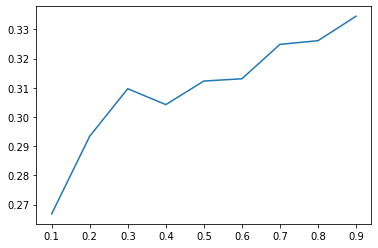

In [53]:
x_labels = []
y_labels = []
for key in result_dict:
    x_labels.append(key)
    y_labels.append(result_dict[key]['avg_recall'])

plt.plot(x_labels,y_labels)
plt.show()

# from around 30 it doesn't really matter

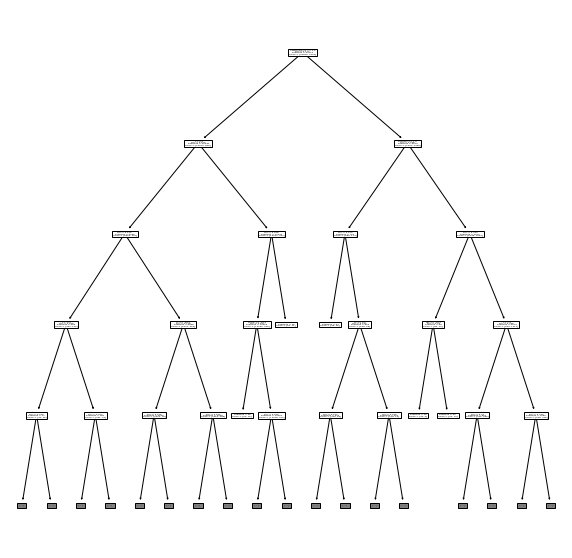

In [18]:
plt.figure(figsize=(10,10))
tree.plot_tree(clf,feature_names = feature_list + ["capitalisation", "end of sentence", "position", "prev_label"], max_depth=4)
plt.show()

In [40]:

test_model = True
max_tries = 100
for min_leaves in np.arange(0,100,5):
    if not test_model:
        break
    avg_prec = 0
    avg_recall = 0
    avg_f1 = 0
    avg_acc = 0
    for itteration in range(max_tries):
        total_sentences = len(set(sentence_idx))
        split = 0.8
        rng = default_rng()
        training_sentence_ids = rng.choice(total_sentences, size=int(total_sentences*split), replace=False)
        test_sentence_ids = [i for i in range(total_sentences) if i not in training_sentence_ids]

        training_id_list = []
        test_id_list = []
        for i, item in enumerate(sentence_idx):
            if item in training_sentence_ids:
                training_id_list.append(i)
            else:
                test_id_list.append(i)

        training_feature_matrix = np.array([feature_matrix[i] for i in training_id_list])
        training_label_matrix = np.array([label_matrix[i] for i in training_id_list])
        test_feature_matrix = np.array([feature_matrix[i] for i in test_id_list])
        test_label_matrix = np.array([label_matrix[i] for i in test_id_list])

        if min_leaves == 0:
            min_leaves = 1
        
        clf = tree.DecisionTreeClassifier(min_samples_leaf=min_leaves)
        clf.fit(training_feature_matrix,training_label_matrix)

        tp = 0
        fp = 0
        fn = 0
        tn = 0
        total = 0
        prediction = clf.predict(test_feature_matrix)
        prev_label = 0
        for i, pred in enumerate(prediction):
            correct_label = test_label_matrix[i]
            if correct_label == 0 and pred == 0:
                tn += 1
            elif correct_label == 0 and pred != 0:
                fn += 1
            elif correct_label == 1 and pred == 0:
                fn += 1
            else:
                tp += 1

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        if tp == 0:
            recall = 0
            precision = 0
            f_1 = 0
        else:
            recall = tp/(tp+fn)
            precision = tp/(tp+fp)
            f_1 = (2*precision*recall)/(precision+recall)
        
        avg_acc += accuracy
        avg_prec += precision
        avg_recall += recall
        avg_f1 += f_1
    
    avg_acc /= max_tries
    avg_prec /= max_tries
    avg_recall /= max_tries
    avg_f1 /= max_tries
    print(f"min_leaves: {min_leaves}")  
    print(f"accuracy: {avg_acc}")
    print(f"recall: {avg_recall}")
    print(f"precision: {avg_prec}" )
    print(f"f_1: {avg_f1}")
    print('-'*69)

    # best leaves is 35

min_leaves: 1
accuracy: 0.8425674175089546
recall: 0.2008975258880133
precision: 1.0
f_1: 0.3333158125973527
---------------------------------------------------------------------
min_leaves: 5
accuracy: 0.8784601888476543
recall: 0.242953480774932
precision: 1.0
f_1: 0.39005305479700597
---------------------------------------------------------------------
min_leaves: 10
accuracy: 0.8962653246612275
recall: 0.27017266925895383
precision: 1.0
f_1: 0.42419581603839857
---------------------------------------------------------------------
min_leaves: 15
accuracy: 0.9038280359344472
recall: 0.2871511817147423
precision: 1.0
f_1: 0.44504859797485663
---------------------------------------------------------------------
min_leaves: 20
accuracy: 0.9092675512339601
recall: 0.3009575456955656
precision: 1.0
f_1: 0.461482807583239
---------------------------------------------------------------------
min_leaves: 25
accuracy: 0.9113753986350193
recall: 0.30350954872263014
precision: 1.0
f_1: 0.464748

In [46]:
result_dict = defaultdict(lambda:(defaultdict(lambda:0)))
min_leaves = 0
with open("results.txt") as file:
    for line in file:
        line = line.rstrip()
        if line == "-"*69:
            continue
        split = line.split(": ")
        label = split[0]
        if label == "min_leaves":
            min_leaves = int(split[1])
            continue
        result = float(split[1])
        result_dict[min_leaves][label] = result
        
print(result_dict)


defaultdict(<function <lambda> at 0x0000018DFE0BA5E8>, {1: defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000018DFDEEE438>, {'accuracy': 0.8611204859939251, 'recall': 0.21017274472168906, 'precision': 1.0, 'f_1': 0.34734337827121337}), 5: defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000018DA82B1EE8>, {'accuracy': 0.8878292461398728, 'recall': 0.23052959501557632, 'precision': 1.0, 'f_1': 0.37468354430379747}), 10: defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000018DFE0BA798>, {'accuracy': 0.9044374563242488, 'recall': 0.31880448318804483, 'precision': 1.0, 'f_1': 0.48347497639282344}), 15: defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000018DFE0BA8B8>, {'accuracy': 0.9094992513724838, 'recall': 0.2879581151832461, 'precision': 1.0, 'f_1': 0.44715447154471544}), 20: defaultdict(<function <lambda>.<locals>.<lambda> at 0x0000018DFE0BA828>, {'accuracy': 0.9096171802054155, 'recall': 0.2954876273653566, 'precision': 1.0, 'f_1': 0.45617977528089887}), 25:

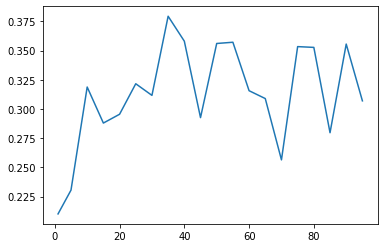

In [51]:
x_labels = []
y_labels = []
for key in result_dict:
    x_labels.append(key)
    y_labels.append(result_dict[key]['recall'])

plt.plot(x_labels,y_labels)
plt.show()

# from around 30 it doesn't really matter

In [152]:
from sklearn.metrics import confusion_matrix

In [154]:
test_labels_flat = []
pred_labels_flat = []
for i in range(len(test_label_matrix)):
    test_idx = list(test_label_matrix[i]).index(1)
    if 1 in list(prediction[i]):
        pred_idx = list(prediction[i]).index(1)
    else:
        pred_idx = 0
    test_labels_flat.append(test_idx)
    pred_labels_flat.append(pred_idx)
conf_matrix = confusion_matrix(test_labels_flat, pred_labels_flat)

In [156]:
print(label_list)
print(conf_matrix)

['O', 'B-prod', 'I-prod', 'B-loc', 'I-loc', 'B-org', 'I-org', 'B-time', 'I-time', 'B-pers', 'I-pers']
[[5107    0    5   42   16    3   45   18   97   23  416]
 [   4    0    0    0    0    1    0    0    0    0    0]
 [   7    0    0    0    0    0    0    0    0    0    0]
 [  43    0    0   20    3    2    0    0    0    2   11]
 [  54    0    0    8    3    1    1    0    0    0    5]
 [  17    0    0    2    1    0    0    0    0    2    4]
 [  43    0    0    2    0    0    0    0    1    3    5]
 [   4    0    0    0    0    0    0    0    0    1    1]
 [  23    0    0    0    1    0    0    0    0    0    2]
 [  52    0    0    8    4    1    0    0    2   15    9]
 [ 100    0    0   10   11    1    2    0    4   16   71]]
